# Welcome to GRC ML Hackathon Challenge A!

This challenge is a collaborative effort to perform data science using a collection of publications.  During this challenge, we will focus on pin-fin heat exchangers. The approach used is nearly identical to an anlysis which involving the NASA Taxonomy and USAF SBIR. That notebook for that analysis has been graciously shared with us by Charles Liles (charles.a.liles@nasa.gov), and can be read here: https://visualization.larc.nasa.gov/dash/notebooks/SBIR_LDA.

The data used for Challenge A is open source, and it was graciously provided by Karsten Look (karsten.look@nasa.gov).

This notebook performs the same latent Dirichlet allocation (LDA) topic modeling on the heat exchanger dataset as in the previously posted example. Some participants will will leverage inexpensive Google Cloud Storage for hosting the data, while others may use Google CoLab (via Google Drive) or storage available on a local computer such as a laptop. If using Google Cloud Storage, you can skip directly to this section by clicking this link: <a href='#cloud_storage'>Cloud Storage Read/Write Demo'</a>. If using Google CoLab, you can skip directly to section... #TODO include section on reading data from Google CoLab. And running the notebook locally, you can reference #TODO include section for reading data locally.

We will also perform t-SNE on vectorized heat exchanger data and interactive visualization using the Python bokeh library.  This link: <a href='#tsne_bokeh'>t-SNE and bokeh Visualization'</a> can be clicked to skip directly to this section of the notebook.

## Import Software Dependencies and Define Functions

We will next import all Python libraries needed for model generation below.  We will also build a function to handle entity extraction from text, stopword removal, and snowball stemming.  Stop words are common word such as "a" and "the" which are not useful for NLP machine learning; you can read more about stop word removal here: https://en.wikipedia.org/wiki/Stop_words. Stemming is a means of transforming words to their root form. For example, the terms "radiate", "radiates", and "radiation" would all transform to a root form of "radiat" after stemming.  More information about Snowball stemming is available here: https://en.wikipedia.org/wiki/Snowball_(programming_language).

In [4]:
# Filter deprecation warning
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
# Uncomment the below lines if these dependencies are not already installed
#!pip install --upgrade scispacy
#!pip install --upgrade spacy
#!pip install --upgrade gensim
#!pip install --upgrade pyLDAvis

# Uncomment the below line if en_core_sci_sm is not loaded on your system.
!pip install --upgrade https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz

#uncomment if you need to read the data files from google cloud storage
from google.cloud import storage

#uncomment if you need to read data in from Google Drive that's mounted to a CoLab notebook
#from google.colab import drive

import time
import bokeh
from sklearn.manifold import TSNE
import pandas as pd
import scispacy
import spacy
import string
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
from gensim import similarities
from sklearn.neighbors import NearestNeighbors
from nltk.corpus import stopwords  
from nltk.stem.snowball import SnowballStemmer
from scipy.spatial.distance import jensenshannon
import numpy as np
from google.cloud import storage

import en_core_sci_sm
nlp = en_core_sci_sm.load()
#nlp = spacy.load('en_core_sci_sm')

import nltk
# Uncomment the below line if nltk's stopwords are not already on your system.
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer('english')

from bokeh.models import HoverTool, CustomJS, ColumnDataSource
from bokeh.palettes import viridis, Viridis256, magma, Turbo256, linear_palette
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz (17.0 MB)
  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.2.4-py3-none-any.whl size=17161107 sha256=0157be08aa296970697a204e358708a984c333d569725902d1d908c6ecdbe243
  Stored in directory: /home/jupyter/.cache/pip/wheels/89/85/86/61e55599e443157de7b74ce7a016c417173a9876c67a2aa5ad
Successfully built en-core-sci-sm
  Attempting uninstall: en-core-sci-sm
    Found existing installation: en-core-sci-sm 0.2.4
    Uninstalling en-core-sci-sm-0.2.4:
      Successfully uninstalled en-core-sci-sm-0.2.4


/opt/conda/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/opt/conda/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/opt/conda/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from co

Loading BokehJS ...

`get_entitites` has been modified do some additional cleaning of terms. Several regular expressions have been added to remove additional special characters and whitespace.

In [5]:
def get_entities(temp_article):
    '''
    A function for preprocessing an article's text.  Spacy's en_core_sci_sm library is used to identify scientfic domain terms. 
    Stopword removal and snowball stemming is then used to cleanup each of term.
    Arg:
        temp_article: the string input for preprocessing
    Returns:
        temp_entities: a list of preprocessed terms
    '''
    if len(temp_article) > nlp.max_length:
        nlp.max_length = len(temp_article)
    doc = nlp(temp_article)
    temp_entities = []
    for n in doc.ents:
        temp_str = ''
        for w in n:
            if w not in stop_words:
                w = w.lower()
                w = re.sub('\[.*?\]', '', w)
                w = re.sub('https?://\S+|www\.\S+', '', w)
                w = re.sub('<.*?>+', '', w)
                w = re.sub('[%s]' % re.escape(string.punctuation), '', w)
                w = re.sub('\n', '', w)
                w = re.sub('\w*\d\w*', '', w)
                w = re.sub(r"\s+"," ", w)
                
                if str(w).isalpha():
                    temp_str += stemmer.stem(str(w)) + ' '
                else:
                    temp_str += str(w) + ' '
                    
        temp_entities.append(temp_str.strip())
    return temp_entities

We will now move forward with our preprocessing and LDA visualizations.  If you are already familiar with this work from the previous notebook, you can skip to t-SNE/visualization by following this link: <a href='#tsne_bokeh'>t-SNE and bokeh Visualization'</a>.

The team has already cleaned up the PDF articles, with the formatted version saved to `Combined_Output.txt`. Artciles in the file are newline delimited.

# Reading the data
For this challenge, there are threee different ways you can read the data.
1. From GCP Cloud storage
2. From Google Drive
3. From your local harddrive.

## From GCP Cloud storage
To read from GCP Cloud storage, we'll use the bucket ID variable and `google.cloud.storage` to connect to the bucket, and download the file a a string. The method name `download_as_string` is a little misleading. What's returned is a bytes object, so we need to decode it using `decode("utf-8")` to convert it to a Python string. All the articles are contained within a single string, so to go to a list of articles we use `split("\n")` to split the string using newline characters as the delimiter.

To preview the data, we only show the first 500 characters for the first few articles. Be careful when printing the downloaded bytes object, string, and list within JupyterLab and on Google Cloud. Trying to print everything might result in warnings, errors, or the notebook locking up.

In [6]:
BUCKET_ID=""
client = storage.Client()
bucket = client.get_bucket(BUCKET_ID)
blob = bucket.get_blob("challenge-ab/processed/Combined_Output.txt")
data = blob.download_as_string().decode("utf-8")
data = data.split("\n")

print("\n\n".join((data[0][:500], data[1][:500], data[2][:500])))

doi:10.1016/j.ijheatmasstransfer.2007.11.028 Available online at www.sciencedirect.com www.elsevier.com/locate/ijhmt  International Journal of Heat and Mass Transfer 51 (2008) 33253341 Analysis of the 1D heat conduction problem for a single fin with temperature dependent heat transfer coefficient  Part II.  Optimum characteristics of straight plate and cylindrical pin fins  I.N. Dulkin *, G.I. Garasko  All-Russian Electrical Engineering Institute, 12 Krasnokazarmennaya Street, 111250 Moscow, Rus

Heat transfer and flow structure characterization for pin fins produced by cold spray additive manufacturing International Journal of Heat and Mass Transfer 98 (2016) 650661 Contents lists available at ScienceDirect  International Journal of Heat and Mass Transfer  journal homepage: www.elsevier .com/locate / i jhmt Heat transfer and flow structure characterization for pin fins produced by cold spray additive manufacturing http://dx.doi.org/10.1016/j.ijheatmasstransfer.2016.03.069 0017-9310/ 2

## Fit Heat Exchanger Articleswith a Bag of Words Vectorizer

We will set up a bag of words vectorizer below.  This is a means of representing an article or document via the number of word occurences within it.  We will then fit this vectorizer to our heat exchanger data. Before creating the bag of words, we print the first 5000 characters of the first article, to help visually inspect the text. We also create a word cloud to visually look at word frequency within the corpus.

In [14]:
print(result[0][:5000])

 naval postgraduate school monterey california thesis approved for public release distribution is unlimited an empirical study of a pin fin heat exchanger in laminar and turbulent flow by jeffrey w summers december thesis advisor ashok gopinath this page intentionally left blank i report documentation page form approved omb no public reporting burden for this collection of information is estimated to average hour per response including the time for reviewing instruction searching existing data sources gathering and maintaining the data needed and completing and reviewing the collection of information send comments regarding this burden estimate or any other aspect of this collection of information including suggestions for reducing this burden to washington headquarters services directorate for information operations and reports jefferson davis highway suite arlington va and to the office of management and budget paperwork reduction project washington dc agency use only leave blank rep

In [15]:
#!pip install --upgrade Wordcloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

<class 'list'>


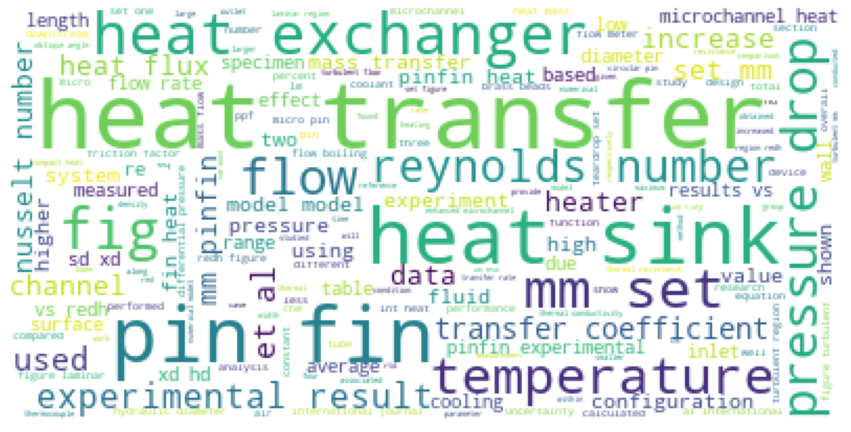

In [16]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue').generate(' '.join(data))
plt.figure( figsize=(15,15) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Next, we create a bag of words using scikit-learns CountVectorizer. `tokenizer`, `min_df`, and `max_df` are all parameters to reduce the size of our bag of words. `get_entities` is a method designed to significant data cleaning, including stemming, removal of stop words, and removing unwanted characters from text like special characters. `min_df` and `max_df` limit words based off the minimum and maximum number of documents they appear in.

In [17]:
bow_vector = CountVectorizer(tokenizer=get_entities, min_df=2, max_df=5, ngram_range=(1,3))
data_vectorized = bow_vector.fit_transform(result)

In [18]:
data_vectorized

<10x1383 sparse matrix of type '<class 'numpy.int64'>'
	with 3470 stored elements in Compressed Sparse Row format>

## Define the LDA Model and Fit to the Vectorized Data

We can now define our LDA model and fit it to our vectorized heat exchanger data.  LDA requires a user to pre-select the number of topic clusters to which the document corpus will be fit.  In this case, we will select 10 clusters for topic modeling.

In [19]:
cluster_count = 10

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=cluster_count,               # Number of topics
                                      #doc_topic_prior=1.0,
                                      max_iter=100,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

In [20]:
lda_output = lda_model.fit_transform(data_vectorized)

## View Fitted Topics

Now that we have fit our LDA model, let's interactively view the fitted model's in a 2D projection below.  A user can hover over topics on the left-hand side and see the top-30 most relevant terms for the topic on the right hand side.  Users can also click on words listed on the righthand side and see their usage throughout all of the fitted model clusters.

The interactive user-interface below helps a user intuitively understand goodness of fit from the original document corpus.

In [21]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, bow_vector, mds='tsne', sort_topics=False)
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1   0.014100
1       0.648955  71.707100       2        1  10.610333
2      71.019684   9.971006       3        1  27.747951
3       3.785981  33.185135       4        1   0.014100
4     -42.666500  -9.222070       5        1  12.136185
5      -3.621689 -43.526516       6        1   0.014100
6      -3.632402  -4.171708       7        1  23.580155
7     -36.584400  35.804413       8        1  12.023160
8      44.391380  50.615383       9        1  12.009032
9      40.235809 -31.591665      10        1   1.850884, topic_info=                   Term       Freq      Total Category  logprob  loglift
1133           specimen  87.000000  87.000000  Default  30.0000  30.0000
784   microchannel heat  66.000000  66.000000  Default  29.0000  29.0000
783        microchannel  70.000000  70.000000  Default  28.0000  28.0000
511           heat sink  84.000000  84.000000  Default  27.0000  27.0000
189             coolant  53.000000  53.000000  Default  26.0000  26.0000
...                 ...        ...        ...      ...      ...      ...
1137              squar   0.533492   6.379345  Topic10  -5.5036   1.5081
343               evalu   0.533490  10.592525  Topic10  -5.5036   1.0010
1069               room   0.533486   2.785852  Topic10  -5.5036   2.3366
161             connect   0.533481   3.867221  Topic10  -5.5036   2.0086
54              assembl   0.533480   4.703885  Topic10  -5.5036   1.8128

[614 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
3         3  0.853968             accur
3         5  0.085397             accur
9         5  0.248699       actual heat
9         8  0.746097       actual heat
11        7  0.423035           adepart
...     ...       ...               ...
1368      8  0.807551  woodcock plawski
1372      2  0.437339              xray
1372      5  0.437339              xray
1376      3  0.421006              yoav
1376      8  0.421006              yoav

[880 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# t-SNE and bokeh Visualization<a id='tsne_bokeh'></a>

We will now perform t-distributed stochasting neighbor embedding (t-SNE) on our vectorized heat exchanger articles from the previous step.  t-SNE is a non-linear means of reducing multiple dimensions to two or three dimensions for visualization.  After using t-SNE to project our vectorized SBIR documents into 2D, we will plot the documents and assign colors to them based on the previous LDA topic modeling cluster assigned.

First, we need to determine to which categories LDA assigned each document.

In [151]:
top_cluster = []
for n in range(lda_output.shape[0]):
    categ = np.argwhere(lda_output[n,:] == np.amax(lda_output[n,:]))
    top_cluster.append(str(categ[0][0]+1))

Next, we will convert our vectorized heat exchanger data from a sparse matrix to a dense one and then perform t-SNE.

In [70]:
test = data_vectorized.todense()

In [71]:
tsne = TSNE(random_state=2017, perplexity=30, n_iter=5000)#, early_exaggeration=120)
embedding = tsne.fit_transform(test)

Let's see how many unique categories were assigned to our documents during LDA topic modeling.  We originally told the algorithm to cluster the heat exchanger documents into 10 topics.  However, some of these topics were fairly small per our visualization above.  Some topics may not be assigned to any document as the primary category.

In [72]:
unique_cats = list(set(top_cluster))
unique_cats_count = len(unique_cats)
print('There are ' + str(unique_cats_count) + ' unique categories in our dataset.')

There are 8 unique categories in our dataset.


Only 10 of our categories were assigned as primary topics for our heat exchanger document collection.  A second iteration of LDA could be performed with only 6 categories in the future.  We will skip this step for now though and use our unique category count for building appropriate bokeh color palette. 

In [73]:
viridis_spec = viridis(unique_cats_count)
magma_spec = magma(unique_cats_count)
turbo_spec = linear_palette(Turbo256, unique_cats_count)

Next, let's visualize our t-SNE reduced dimensions and also use the original LDA cluster assignment for a color palette.  We will also use a hover functionality to show the index of the heat exchanger document, the document's title, and also the category # assigned to the document by the LDA clustering algorithm above.

In [74]:
source = ColumnDataSource(data=dict(
    x=embedding[:,0],
    y=embedding[:,1],
    top_cluster=top_cluster
))

TOOLTIPS = [
    ("index", '$index'),
    ("Title", '@desc'),
    ('Category', '@top_cluster')
]

In [75]:
p = figure(title="t-SNE Projection of Vectorized Heat Exchangers", tooltips=TOOLTIPS, plot_height=800, plot_width=800)
p.circle('x', 'y', size=10, source=source, fill_alpha=0.75, fill_color=factor_cmap('top_cluster', palette=magma_spec, factors=top_cluster))
show(p)

## Summary

This is a nice vizualization of the original vectorized heat exchanger documents.  It is possible to hover and see where similar documents are clustering together.  The t-SNE algorithm has projected the vectorized documents into a 2D space where similar documents should be grouped together.  For example, at roughly coordinates (7, 3), a user can hover their mouse over a darker blue grouping of heat exchanger documents.  They also all were assigned to category 4 by the original LDA clustering algorithm.  

This plot has several interactive features.  Users can scroll in and out as well as draw boxes for zooming in.  The number of colors is a bit much.  It would be desirable to rerun this notebook in the future with less color categories (and less LDA clusters).

This has been an initial exploration of leveraging scikit-learn for analysis as well as applying t-SNE to heat exchanger vectorized document and visualizing results using bokeh in Python.  For any questions on this notebook, please reach out to Charles Liles (charles.a.liles@nasa.gov) or Karsten Look (karsten.look@nasa.gov).